# DNN Feedforward con Cromagramas
Veamos qué tal nos va con esto...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import importlib
import math
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import join
import re
import sys
import torch
import ipynb.fs.defs.music_functions as music # Importa notebook de funciones musicales.
#import ipynb.fs.full.dataset_functions as data # Importa notebook de funciones para el dataset.
import ipynb.fs.defs.dataset_functions as data # Importa notebook de funciones para el dataset.S
# from ipynb.fs.full.dataset_functions import create_chord_annotation_database # Importa notebook de funciones para el dataset.

plt.rcParams['agg.path.chunksize'] = 10000  # Permite plotear grandes vectores.
eps = np.finfo(float).eps  # épsilon matemático (float más pequeño).


Inputs al sistema

In [3]:
k_fold = 1  # K-Fold Validation. La idea es que sea un input por bash.
f_b0 = 30.87  # Frecuencia del B0 en Hz. Nota musical más baja que ingresa a la red.
n_quarter_tones = 178 # Núm. de cuartos de tono que ingresan a la red.
win_length = 4 * 2048 # Largo de la ventana de la STFT.
overlap = int(win_length * 0.5) # Traslape entre ventanas (50% del largo de la ventana).
n_fft = win_length # Núm. de puntos de la FFT. Debe ser potencia de 2 (más eficiente).
f_inic = music.quarter_tone_previous(f_b0) # Cuarto de tono anterior.
print(f_inic)

29.99119102341181


Inputs de la red neuronal

In [4]:
concatenated_frames = 15 # Núm. de frames concatenados que ingresan a la red. Permite contexto.
keep_prob = 0.8  # Probabilidad de ocurrencia de alguna hidden unit.
batch_size = 512  # Número de entradas a la red (entrenamiento).
l_supervector = concatenated_frames * n_quarter_tones # Largo del supervector de entrada.
l_chromagram = 12 # Núm. de elementos del cromagrama.
l_hidden = 512 # Núm. de elementos de las hidden layers.



# Ejecución del código
Obtención de los sets de entrenamiento, validación y prueba. Se realiza mediante un muestro aleatorio estratificado. Los estratos corresponden a los acordes musicales.

In [5]:
f_length = 2 * 2048.0 / 44100
db_path = os.getcwd() + '/Database'
df = data.create_chord_annotation_database(path=db_path, frame_length=f_length)
index_train, index_val, index_test, ch_ocurrence = data.stratified_set_split(df, rseed=0)
index_train_reserva = index_train
index_val_reserva = index_val
index_test_reserva = index_test

Reading chord annotation data from /home/vpoblete/TesisLuis/2019 - DNN Chromagrams/Database
Creating train, validation and test indices


# Ejecución de la Red Neuronal
Primero las definiciones de la red.

In [6]:
class FeedForwardNet(torch.nn.Module):
    
    def __init__(self, hid_neur=512, drop_prob=0.2):
        super(FeedForwardNet, self).__init__()
        self.dropout = torch.nn.Dropout(p=drop_prob)
        self.hid_lay1 =torch.nn.Linear(in_features=147, out_features=hid_neur)
        self.hid_lay2 = torch.nn.Linear(in_features=hid_neur, out_features=hid_neur)
        self.hid_lay3 = torch.nn.Linear(in_features=hid_neur, out_features=hid_neur)
        self.out_layer = torch.nn.Linear(in_features=hid_neur, out_features=12)
        self.act_fun_hid = torch.nn.ReLU()
        self.act_fun_out = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        # print(x.dtype)
        h1 = self.act_fun_hid(self.dropout(self.hid_lay1(x)))
        h2 = self.act_fun_hid(self.dropout(self.hid_lay2(h1)))
        h3 = self.act_fun_hid(self.dropout(self.hid_lay3(h2)))
        # y = self.act_fun_out(self.out_layer(h3))
        y = self.out_layer(h3)
        return y

net = FeedForwardNet(hid_neur=512)
net = net.cuda()
# loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCELoss()
loss_function = torch.nn.BCEWithLogitsLoss(reduction='mean')
learning_rate = 0.001 # Razón de aprendizaje de la red.
optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
l_train = l_valid = []

In [7]:
index_train = index_train_reserva
index_val = index_val_reserva

<Figure size 432x288 with 0 Axes>

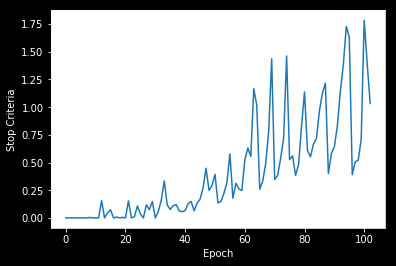

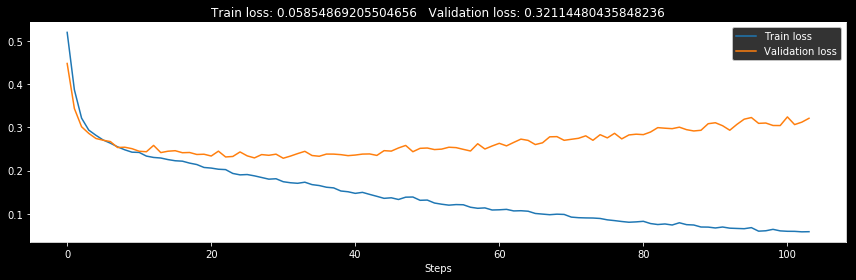

Ha finalizado el entrenamiento


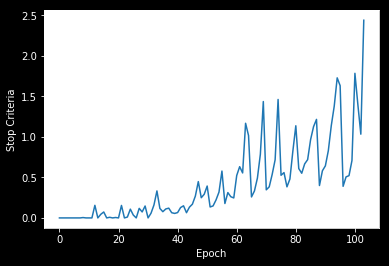

In [8]:
import hiddenlayer as hl
history1 = hl.History()
canvas1 = hl.Canvas()
short_experiment = True
show_training = True
batch_size = 512
batch_size_val = batch_size * 4
net_parameters_path = 'Resultados/Parametros-DNN'
weights_path = net_parameters_path + ".weights"
if short_experiment:
    index_train = index_train[0:batch_size * 20]
    index_val = index_val[0:batch_size_val * 2]
else:
    index_train = index_train_reserva
    index_val = index_val_reserva
n_frames_dataset = np.size(index_train, 0)
iterations = int(round(float(n_frames_dataset / batch_size)))
n_frames_valid  = np.size(index_val, 0)
iterations_valid = int(round(float(n_frames_valid / batch_size_val)))
print(iterations, iterations_valid)
error_train = 1000
error_val_opt = 1000
k_seq = 5
# error_train = np.zeros(k_seq)
error_train_list = [0.] * k_seq
early_stop_criteria_value = 2.0
# print(error_train)
# print(n_frames_dataset, iterations)
epch = []
stp_crt = []
for epoch in range(300):
    # TRAIN
    # print("Epoch " + str(epoch))
    np.random.shuffle(index_train)
    train_samples = 0
    loss_train = 0.0
    for idx in range(iterations):
        pair_for_train = index_train[idx * batch_size : (idx  + 1) * batch_size]
        df_index, frame = [x[0] for x in pair_for_train], [x[1] for x in pair_for_train]
        tstart = [df['tstart'].loc[x] for x in df_index]
        tend = [df['tend'].loc[x] for x in df_index]
        songs = [join('Database', df['disk'][x], 'npy', df['track'][x][:-4] + '_(prueba).npy') for x in df_index]
        times_in_songs = [join('Database', df['disk'][x], 'timevector', df['track'][x][:-4] + '_(prueba).npy') for x in df_index]
        times_in_songs = [np.load(x).tolist() for x in times_in_songs]
        selected_frames = []
        for cont, t_song in enumerate(times_in_songs):
            frames_within_timerange = [n for n, t in enumerate(t_song) if t >= tstart[cont] and t < tend[cont]]
            selected_frames.append(frames_within_timerange[frame[cont] - 1])  # <---- REVISAR!!
        x_input = np.array([np.load(song)[:, selected_frames[idx]] for idx, song in enumerate(songs)])
        chords = [df['chord'][x] for x in df_index]
        x_input = torch.tensor(x_input, dtype=torch.float32)
        x_input = x_input.cuda()
        y_label = torch.tensor(music.chord_dict(chords), dtype=torch.float32)
        y_label = y_label.cuda()
        optimizer.zero_grad()
        prediction = net.forward(x_input)
        loss = loss_function(prediction, y_label)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        # print(np.array(loss_train))
    error_train_list = error_train_list[1:]
    error_train_list.append(loss_train / iterations)
    error_train = np.array(error_train_list)
    progress = 1000 * (np.sum(error_train) / (k_seq * np.min(error_train)) - 1) if np.min(error_train) != 0 else 0  # Progress (Early Stopping)
    # error_train = np.concatenate((error_train[:-1], np.array([loss_train])), axis=1)
    
    train_samples = 1
    history1.log(epoch, loss_train=loss_train/iterations)
    
    # VALIDATION
    loss_valid = 0.0
    valid_samples = 0
    for jdx in range(iterations_valid):
        pair_for_valid = index_val[jdx * batch_size_val : (jdx  + 1) * batch_size_val]
        tstart = [df['tstart'][idx] for (idx, frm) in pair_for_valid]
        tend = [df['tend'][idx] for (idx, frm) in pair_for_valid]
        songs = [join('Database', df['disk'][idx], 'npy', df['track'][idx][:-4] + '_(prueba).npy') for (idx, frm) in pair_for_valid]
        times_in_songs = [join('Database', df['disk'][idx], 'timevector', df['track'][idx][:-4] + '_(prueba).npy') for (idx, frm) in pair_for_valid]
        times_in_songs = [np.load(x).tolist() for x in times_in_songs]
        frm = [frm for (idx, frm) in pair_for_valid]
        selected_frames = []
        for cont, t_song in enumerate(times_in_songs):
            frames_within_timerange = [n for n, t in enumerate(t_song) if t >= tstart[cont] and t < tend[cont]]
            selected_frames.append(frames_within_timerange[frm[cont] - 1])  # <---- REVISAR!!
        input_array = np.array([np.load(song)[:, selected_frames[idx]] for idx, song in enumerate(songs)])
        chords = [df['chord'][idx] for (idx, frm) in pair_for_valid]
        x_val = torch.tensor(input_array, dtype=torch.float32)
        x_val = x_val.cuda()
        chord_label = torch.tensor(music.chord_dict(chords), dtype=torch.float32)
        chord_label = chord_label.cuda()
        prediction = net.forward(x_val)
        loss = loss_function(prediction, chord_label)
        loss_valid += loss.item()
    error_val = loss_valid / iterations_valid
    if error_val < error_val_opt:
        torch.save(net.state_dict(), weights_path)
        print("Parámetros guardados en epoch " + str(epoch + 1))
    error_val_opt = error_val if error_val < error_val_opt else error_val_opt  # Error óptimo (Early Stopping)
    
    generalization_loss = 100 * (error_val / error_val_opt - 1)   # Error de Generalización (Early Stopping)
    early_stop_criteria = generalization_loss / progress if progress != 0 else 0
    # print(error_val, error_val_opt, generalization_loss)
    #print("Epoch: " + str(epoch) + ". Progress: " + str(round(progress, 3)) + ". Generalization loss: " + 
    #      str(round(generalization_loss, 3)) + ". Stop Criteria: " + str(round(early_stop_criteria, 3)) )
    valid_samples = 1
    history1.log(epoch, loss_valid=loss_valid / iterations_valid)
    if show_training:
        epch.append(epoch)
        stp_crt.append(early_stop_criteria)
        with plt.rc_context({'axes.edgecolor':'white',  'axes.labelcolor': 'white', 'xtick.color':'white',
                            'ytick.color':'white', 'figure.facecolor':'black', 'text.color': 'white',
                            'legend.facecolor': 'black'}):
            plt.figure(1)
            with canvas1:
                canvas1.draw_plot([history1["loss_train"], history1["loss_valid"]], 
                                  labels=["Train loss", "Validation loss"])
            plt.figure(2)
            plt.plot(epch, stp_crt)
            plt.xlabel("Epoch")
            plt.ylabel("Stop Criteria")
        
    if early_stop_criteria > early_stop_criteria_value:
        print("Ha finalizado el entrenamiento")
        break
    # print(l_valid)

# Sala de Pruebas

tensor([[-0.4988, -0.2627, -0.0983,  ...,  0.6972,  0.4693,  0.2550],
        [ 1.1484,  0.4591,  0.5275,  ...,  1.8723,  1.9190,  1.7726],
        [ 0.8062,  0.6026,  1.1140,  ...,  2.0996,  2.2913,  2.4690],
        ...,
        [ 2.5273,  2.8767,  2.8894,  ...,  2.5327,  2.3135,  2.3185],
        [ 2.5098,  2.0262,  1.6721,  ...,  3.1104,  3.0766,  3.0537],
        [-0.9032,  0.2539,  0.2210,  ...,  2.5079,  2.3263,  2.7138]],
       device='cuda:0')
tensor([[9.4382e-02, 4.4764e-02, 5.0479e-01,  ..., 9.2432e-01, 8.0742e-06,
         3.4169e-05],
        [3.8952e-06, 9.9719e-01, 3.0798e-03,  ..., 9.9991e-01, 8.3359e-07,
         7.0385e-05],
        [9.9940e-01, 7.8017e-05, 7.3295e-05,  ..., 1.4372e-02, 3.9280e-06,
         1.4684e-04],
        ...,
        [9.9997e-01, 3.0471e-07, 1.7290e-05,  ..., 1.0191e-05, 7.6917e-06,
         3.6543e-05],
        [1.6416e-02, 9.8163e-01, 1.0780e-03,  ..., 9.8158e-01, 3.4483e-04,
         1.2892e-02],
        [9.9858e-01, 1.0072e-03, 7.0396e-10,

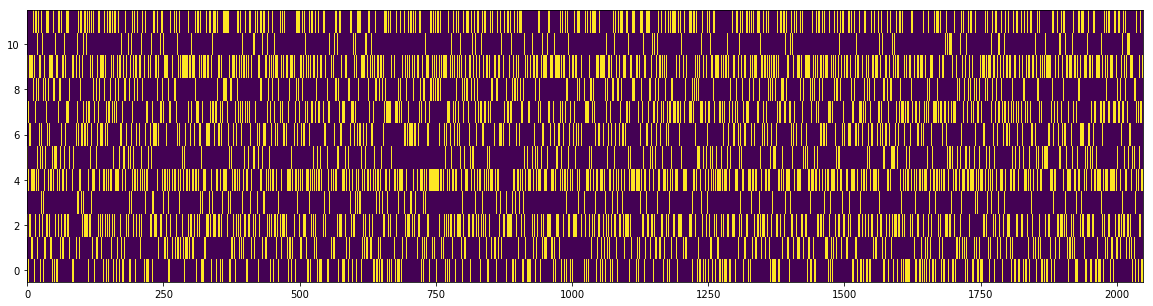

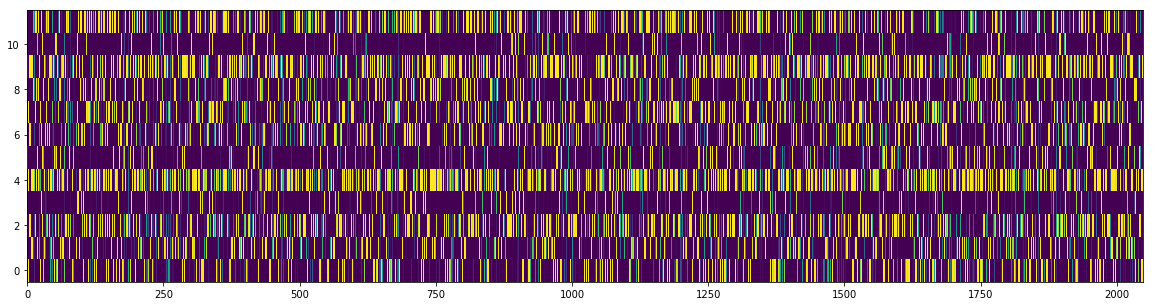

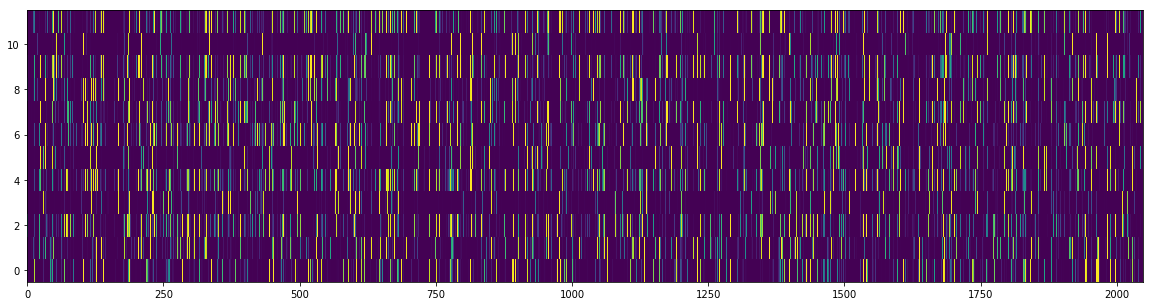

In [9]:
#print(loss_valid)
# print(loss.item())
# print(loss_valid / iterations_valid)
# print(chords)
# print(chord_label)
# print(music.chord_dict(chords))
net.load_state_dict(torch.load(weights_path))
print(x_val)
pred = torch.sigmoid(net.forward(x_val))
# pred = net.forward(x_val)
print(pred)
pred = pred.cpu()
pred = pred.data.numpy()
# print(pred.data.numpy())
chord_label_cpu = chord_label.cpu()
ch_lab = torch.tensor(music.chord_dict(chords), dtype=torch.float32)
plt.rcParams['figure.figsize'] = [20, 5]
# acordes = ch_lab[50:100, :].transpose(0,1)
acordes = ch_lab.transpose(0,1)
acordes = acordes.detach().numpy()
with plt.rc_context({'axes.edgecolor':'black',  'axes.labelcolor': 'black', 'xtick.color':'black',
                        'ytick.color':'black', 'figure.facecolor':'white', 'text.color': 'white',
                        'legend.facecolor': 'black'}):
    # plt.imshow(chord_label_cpu, origin='origin', aspect='auto')
    plt.figure(1)
    #plt.imshow(ch_lab[50:100, :].transpose(0,1), origin='origin', aspect='auto')
    plt.imshow(ch_lab.transpose(0,1), origin='origin', aspect='auto')
    #plt.imshow(ch_lab.transpose(0,1), origin='origin', aspect='auto')
    plt.figure(2)
    #plt.imshow(pred[50:100, :].T, origin='origin', aspect='auto')
    plt.imshow(pred.T, origin='origin', aspect='auto')
    plt.figure(3)
    #plt.imshow(np.abs(acordes - pred[50:100, :].T), origin='origin', aspect='auto')
    plt.imshow(np.abs(acordes - pred.T), origin='origin', aspect='auto')
    #plt.imshow(pred.T, origin='origin', aspect='auto')

In [10]:
''' EARLY STOPPING '''


' EARLY STOPPING '

In [11]:
quarter_tones = []
quarter_tones_frequency = []
music_notes = ['B0', 'C1', 'C#1', 'D1', 'D#1', 'E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1',
              'B1', 'C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2',
              'B2', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3',
              'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4',
              'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5',
              'B5', 'C6', 'C#6', 'D6', 'D#6', 'E6', 'F6', 'F#6', 'G6', 'G#6', 'A6', 'A#6',
              'B6', 'C7', 'C#7', 'D7', 'D#7', 'E7', 'F7', 'F#7', 'G7', 'G#7', 'A7', 'A#7',
              'B7', 'C8', 'C#8', 'D8', 'D#8']
for idx, note in enumerate(music_notes):
    actual_note = f_b0 * (2 ** (idx / 12.0))
    quarter_tones.append(note)
    quarter_tones.append(' ')
    quarter_tones_frequency.append(actual_note)
    quarter_tones_frequency.append(music.quarter_tone_posterior(actual_note))
n_quarter_tones = len(quarter_tones)
f_inicial = 23 # cuarto de tono debajo de B1
f_final = 169 # cuarto de tono encima de B7
quarter_tones = quarter_tones[f_inicial:f_final+1]
print(quarter_tones)

[' ', 'B1', ' ', 'C2', ' ', 'C#2', ' ', 'D2', ' ', 'D#2', ' ', 'E2', ' ', 'F2', ' ', 'F#2', ' ', 'G2', ' ', 'G#2', ' ', 'A2', ' ', 'A#2', ' ', 'B2', ' ', 'C3', ' ', 'C#3', ' ', 'D3', ' ', 'D#3', ' ', 'E3', ' ', 'F3', ' ', 'F#3', ' ', 'G3', ' ', 'G#3', ' ', 'A3', ' ', 'A#3', ' ', 'B3', ' ', 'C4', ' ', 'C#4', ' ', 'D4', ' ', 'D#4', ' ', 'E4', ' ', 'F4', ' ', 'F#4', ' ', 'G4', ' ', 'G#4', ' ', 'A4', ' ', 'A#4', ' ', 'B4', ' ', 'C5', ' ', 'C#5', ' ', 'D5', ' ', 'D#5', ' ', 'E5', ' ', 'F5', ' ', 'F#5', ' ', 'G5', ' ', 'G#5', ' ', 'A5', ' ', 'A#5', ' ', 'B5', ' ', 'C6', ' ', 'C#6', ' ', 'D6', ' ', 'D#6', ' ', 'E6', ' ', 'F6', ' ', 'F#6', ' ', 'G6', ' ', 'G#6', ' ', 'A6', ' ', 'A#6', ' ', 'B6', ' ', 'C7', ' ', 'C#7', ' ', 'D7', ' ', 'D#7', ' ', 'E7', ' ', 'F7', ' ', 'F#7', ' ', 'G7', ' ', 'G#7', ' ', 'A7', ' ', 'A#7', ' ', 'B7', ' ']


In [12]:
'''
for cont, (index, frame) in enumerate(index_val):
    # print("Valid " + str(cont) + ' de ' + str(len(index_val)))
    # print(df.loc[index])
    album = df['disk'][index]
    track = df['track'][index]
    tstart = df['tstart'].loc[index]
    tend = df['tend'].loc[index]
    song = join('Database', album, 'npy', track[:-4] + '_(prueba).npy')
    times_in_song = np.load(join('Database', album, 'timevector', track[:-4] + '_(prueba).npy'))
    frames_within_timerange = [n for n, t in enumerate(times_in_song) if t >= tstart and t < tend]
    selected_frames = frames_within_timerange[frame - 1]  # <---- REVISAR!!
    # selected_frames = frames_within_timerange[frame]  # <---- REVISAR!!
    input_val = np.load(song)[:, selected_frames]
    chord_val = [df['chord'][index]]
    input_val = torch.tensor(input_val, dtype=torch.float32)
    input_val = input_val.cuda()
    chord_val = torch.tensor(music.chord_dict(chord_val), dtype=torch.float32)
    chord_val = chord_val.cuda()
    prediction = net.forward(input_val)
    loss = loss_function(prediction, chord_val)
    loss_valid += loss.item()
    # l_valid.append(loss.item)
    valid_samples += 1
    if cont > 1000:
        break
'''

'\nfor cont, (index, frame) in enumerate(index_val):\n    # print("Valid " + str(cont) + \' de \' + str(len(index_val)))\n    # print(df.loc[index])\n    album = df[\'disk\'][index]\n    track = df[\'track\'][index]\n    tstart = df[\'tstart\'].loc[index]\n    tend = df[\'tend\'].loc[index]\n    song = join(\'Database\', album, \'npy\', track[:-4] + \'_(prueba).npy\')\n    times_in_song = np.load(join(\'Database\', album, \'timevector\', track[:-4] + \'_(prueba).npy\'))\n    frames_within_timerange = [n for n, t in enumerate(times_in_song) if t >= tstart and t < tend]\n    selected_frames = frames_within_timerange[frame - 1]  # <---- REVISAR!!\n    # selected_frames = frames_within_timerange[frame]  # <---- REVISAR!!\n    input_val = np.load(song)[:, selected_frames]\n    chord_val = [df[\'chord\'][index]]\n    input_val = torch.tensor(input_val, dtype=torch.float32)\n    input_val = input_val.cuda()\n    chord_val = torch.tensor(music.chord_dict(chord_val), dtype=torch.float32)\n    c